# Comparison of MLP vs Transformer-Only Models

Comparison of models, using a dataset of python code. The aim is to find
interesting prompts where an MLP layer is required to accurately predict next tokens.


## Imports

In [1]:
from transformers import AutoTokenizer
from IPython.display import display, clear_output
from ipywidgets import widgets
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from circuitsvis.tokens import colored_tokens
from codegen import infer

## Run the models on the code dataset

Run all models (or load from checkpoints if they already exist).

In [2]:
models = [
        # "NeelNanda/SoLU_1L512W_C4_Code",
        "NeelNanda/SoLU_2L512W_C4_Code",
        # "NeelNanda/SoLU_3L512W_C4_Code",
        # "NeelNanda/SoLU_4L512W_C4_Code",
        # "NeelNanda/SoLU_6L768W_C4_Code",
        # "NeelNanda/SoLU_8L1024W_C4_Code",
        # "NeelNanda/SoLU_10L1280W_C4_Code",
        # "NeelNanda/SoLU_12L1536W_C4_Code",
        # "NeelNanda/GELU_1L512W_C4_Code",
        # "NeelNanda/GELU_2L512W_C4_Code",
        # "NeelNanda/GELU_3L512W_C4_Code",
        # "NeelNanda/GELU_4L512W_C4_Code",
        # "NeelNanda/Attn_Only_1L512W_C4_Code",
        "NeelNanda/Attn_Only_2L512W_C4_Code",
        # "NeelNanda/Attn_Only_3L512W_C4_Code",
        # "NeelNanda/Attn_Only_4L512W_C4_Code",
        # "gpt2",
        # "gpt2-medium"
    ]

results = {}
for model_name in models:
    results[model_name] = infer.run_model(model_name)

results.keys(), list(results.values())[0].shape

(dict_keys(['NeelNanda/SoLU_2L512W_C4_Code', 'NeelNanda/Attn_Only_2L512W_C4_Code']),
 (297257, 1023))

### Get the prompts for this dataset

In [3]:
prompts_dataset = load_dataset("NeelNanda/code-tokenized", split="train")

prompts_tokens: List[List[int]] = []
for prompt_tokens in tqdm(prompts_dataset):
    prompts_tokens.append(prompt_tokens["tokens"])

# Get the prompts tokens
prompts_tokens = np.array(prompts_tokens)

prompts_tokens.shape

Using custom data configuration NeelNanda--code-tokenized-d313277bd840bb66
Found cached dataset parquet (/home/user/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--code-tokenized-d313277bd840bb66/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 297257/297257 [02:34<00:00, 1926.22it/s]


(297257, 1024)

## Model comparison aggregate results

In [4]:
# Get the difference in performance between models
prob_diff = np.exp(results["NeelNanda/SoLU_2L512W_C4_Code"]) \
    - np.exp(results["NeelNanda/Attn_Only_2L512W_C4_Code"])

prob_diff.shape

(297257, 1023)

### Histogram of differences by token

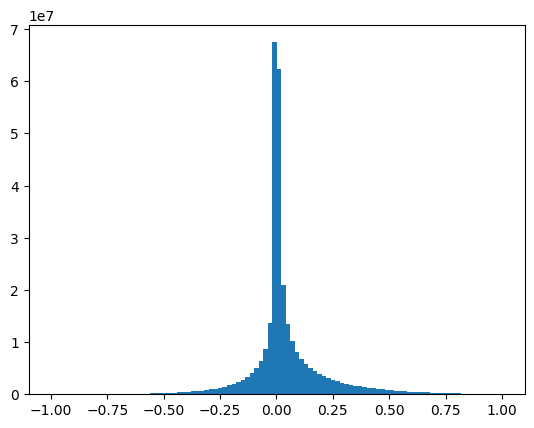

In [5]:
prob_diff_flat: np.ndarray = prob_diff.flatten()
plt.hist(prob_diff_flat, bins=100)
plt.show()

### Histogram of differences by prompt

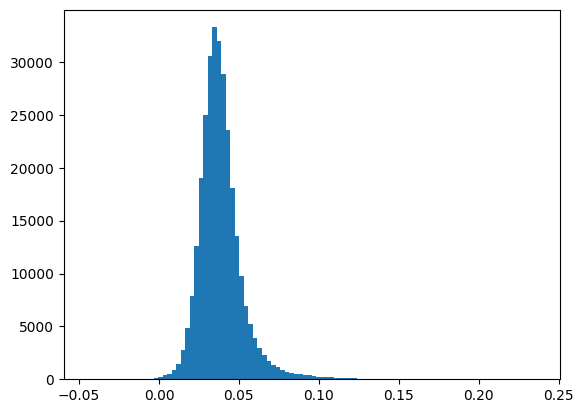

In [6]:
prob_diff_by_prompt = np.mean(prob_diff, axis=-1)
plt.hist(prob_diff_by_prompt, bins=100)
plt.show()

## Prompts that are most impacted by adding MLP layers

array([[<AxesSubplot: title={'center': 'count_significant'}>]],
      dtype=object)

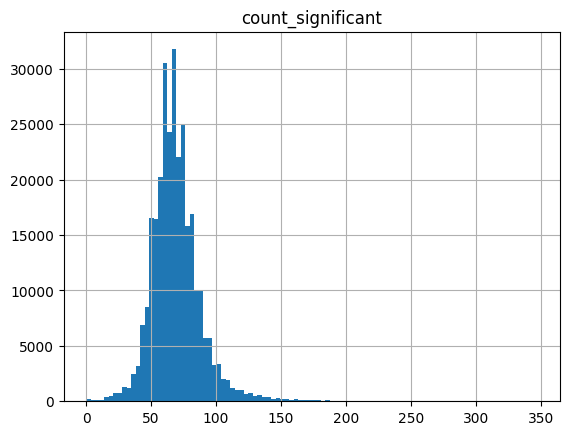

In [7]:
# Rank the prompts by number of tokens that are significantly better with the
# MLP layer
threshold = 0.3
count_prob_diff_above_threshold = np.sum(prob_diff > threshold, axis=-1)
ranked_prompts = pd.DataFrame({"count_significant": count_prob_diff_above_threshold})
ranked_prompts.sort_values(by="count_significant", ascending=False, inplace=True)
prompt_ids_ranked = ranked_prompts.index.values

# Show histogram for the number of tokens that are significantly better, per prompt
ranked_prompts.hist(bins=100)

### Dropdown to view prob diff by token, for different prompts

In [8]:
def show_prob_diff_colored_tokens(prompt_id: int) -> None:
    prompt_token_diff = prob_diff[prompt_id, :]
    
    tokenizer = AutoTokenizer.from_pretrained("NeelNanda/gpt-neox-tokenizer-digits")
    token_strings = [tokenizer.decode(t) for t in prompts_tokens[prompt_id]][0:-1]
    
    return colored_tokens(
        values=prompt_token_diff.tolist(),
        tokens=token_strings,
        min_value=-1,
        max_value=1,
        max_color="green",
    )
    
w = widgets.Dropdown(
    options=[ (f"{ind}: Prompt {prompt_id}", prompt_id) for ind, prompt_id in  enumerate(prompt_ids_ranked[0:1000])],
    description='Prompt ID',
)

out = widgets.Output()
with out:
    display(show_prob_diff_colored_tokens(prompt_ids_ranked[0]))

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with out:
            clear_output()
            display(f"Number above threshold: {count_prob_diff_above_threshold[change['new']]}")
            display(show_prob_diff_colored_tokens(change['new']))

w.observe(on_change)

display(w, out)

Dropdown(description='Prompt ID', options=(('0: Prompt 107976', 107976), ('1: Prompt 245321', 245321), ('2: Pr…

Output()

### Top prompts

In [9]:
# Show top prompts
top_prompts = prompt_ids_ranked[0:1000]
tokenizer = AutoTokenizer.from_pretrained("NeelNanda/gpt-neox-tokenizer-digits")
top_100_prompts = [tokenizer.decode(p) for p in prompts_tokens[top_prompts]]
pd.set_option('display.max_rows', 500)
pd.DataFrame({"prompt": top_100_prompts}).head(300)


,prompt
0,"<|BOS|>903,7904, # 7904\n7905,7906,7907,7908,7..."
1,"<|BOS|>\n self.ipv6test(False, '1111:22..."
2,<|BOS|>123456789512345678961234567897123456789...
3,<|BOS|>\n# Add any paths that contain template...
4,<|BOS|>#add_function_parentheses = True\n\n# I...
5,<|BOS|>title = None\n\n# A shorter title for t...
6,<|BOS|>_theme_path = []\n\n# The name for this...
7,"<|BOS|>\n60\n:'crosswalk',\n61\n:'outdoor',\n6..."
8,<|BOS|>\ntemplates_path = ['_templates']\n\n# ...
9,"<|BOS|>inx documents. If None, it defaults to..."
